# Diffusion Curve Fitting and Modelling

In [1]:
#importing modules:
import os
import math
import csv

import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

from scipy import optimize
import scipy
from scipy.special import erfc

### Checking agreeance of reported and theoretical diffusion coefficient of ammonnium and bromphenol blue

In [2]:
def stokes_einstein_diffusion_coefficient(temperature, dynamic_viscosity, radius):
    'Theorectical coefficient'
    # Boltzmann constant (in J/K)
    boltzmann_constant = 1.380649e-23  # J/K^-1
    # Calculate the diffusion coefficient
    diffusion_coefficient = (boltzmann_constant * temperature) / (6 * math.pi * dynamic_viscosity * radius)
    return diffusion_coefficient

# variables:
temperature_kelvin = 298.15  # Room temperature in K (25°C)
viscosity_water = 0.00100  # Dynamic viscosity of water at 25°C (in kg/(m*s))
ammonium_particle_radius = 1.4700E-10  # radius ammonium (meters)
bromphenolblue_particle_radius = 2.27E-10 # source

#stokes-einstein ammonium
diffusion_coefficient = stokes_einstein_diffusion_coefficient(temperature_kelvin, viscosity_water, ammonium_particle_radius)*10000
print(f"Ammonium stokes-einstein diffusion Coefficient: {diffusion_coefficient:.6e} cm^2/s")

#experimental ammonium
D_AMM =1.95700E-5 #https://www.mdpi.com/1422-0067/23/10/5782 #cm2/s (±10%), ammonium self diffusion coeffcient
print(f"Ammonium experimental diffusion Coefficient: {D_AMM:.6e} cm^2/s")
print('☑ Relative agreeance: using the experimental coefficient for all future code \n')

#stokes-einstein bromophenol blue indicator
diffusion_coefficient = stokes_einstein_diffusion_coefficient(temperature_kelvin, viscosity_water, bromphenolblue_particle_radius)*10000
print(f"Bromphenolblue stokes-einstein diffusion Coefficient: {diffusion_coefficient:.6e} cm^2/s")

#experiemental bromophenol blue indicator
D_BPB = 0.0000044 #https://pubs.acs.org/doi/abs/10.1021/ed066p614
print(f"Bromphenol blue experimental diffusion Coefficient: {D_BPB:.6e} cm^2/s")
print('☑ Relative agreeance: using the experimental coefficient for all future code \n')

print('Reality check: larger molecules have smaller diffusion coefficients: ')
if D_BPB>D_AMM:
    print('BPB coefficent larger')
else:
    print('BPB coefficient is smaller that the ammonium coefficient')

Ammonium stokes-einstein diffusion Coefficient: 1.485592e-05 cm^2/s
Ammonium experimental diffusion Coefficient: 1.957000e-05 cm^2/s
☑ Relative agreeance: using the experimental coefficient for all future code 

Bromphenolblue stokes-einstein diffusion Coefficient: 9.620355e-06 cm^2/s
Bromphenol blue experimental diffusion Coefficient: 4.400000e-06 cm^2/s
☑ Relative agreeance: using the experimental coefficient for all future code 

Reality check: larger molecules have smaller diffusion coefficients: 
BPB coefficient is smaller that the ammonium coefficient


### Importing all local ".txt" files of BPB diffusion

In [22]:
files=(os.listdir())
files=[x for x in files if '.txt' in x] # only text files aka data files
files=files
largeArray=np.loadtxt("BPB_1.txt") #file 1 is excluded from loop by starting range at 1
for i in range(1,len(files)):
    data1=np.loadtxt(files[i])
    largeArray=np.dstack((largeArray,data1))

### Normalizing the intensity data to AU

In [23]:
normalizedArray=[]
for i in range(largeArray.shape[2]):
    #normalizing by intensity at t=0
    subArray=largeArray[:,:,i]
    normalizedArray.append((subArray-np.min(subArray))/(np.max(subArray)-np.min(subArray)))
normalizedArray=np.stack(normalizedArray)

#averaging all lanes
normalizedData=np.average(normalizedArray, axis=0) 

#cropping out agar and normalizing to 1 and 0 (converting to AU)
normalizedData=normalizedData[:,5:480]
normalizedData = ((normalizedData-np.min(normalizedData))/(np.max(normalizedData)-np.min(normalizedData)))

### Plotting normalized (AU) data

C:\Users\lexis\AppData\Local\Temp\ipykernel_19912\2613073267.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('brg')


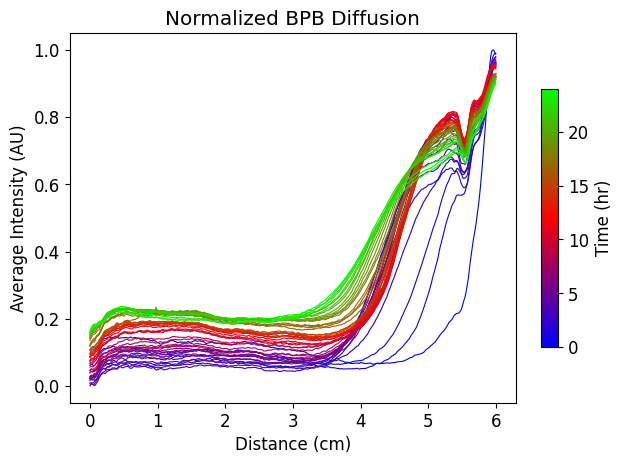

In [24]:
#converting the 475 pixels to centimeters
xData=(np.arange(0,6,6/(normalizedData.shape[1]-0.5)))

#plotting ever time point (24 hour every hour)
cmap = plt.cm.get_cmap('brg')
colors = plt.cm.brg(np.linspace(0, 1, 48))

fig, ax = plt.subplots(1, 1)
for i in np.arange(0,48):
    ax.plot(list(np.flip(xData)), normalizedData[i], color=colors[i], label=i, linewidth=0.8)
plt.ylabel("Average Intensity (AU)")
plt.xlabel("Distance (cm)")
plt.title('Normalized BPB Diffusion')

#setting colorbar
norm = mpl.colors.Normalize(vmin=0, vmax=24)
cax, cbar_kwds = mpl.colorbar.make_axes(ax,
                                        location='right',
                                        fraction=0.05,
                                        pad=0.05,
                                        shrink=0.7,
                                        aspect=15)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='vertical', label='Time (hr)')

plt.show()

### Curve fitting the time series diffusion data to the ERF function

In [28]:
def DIFFUSION_FIT(X, D):
        #curve fitting equation: source?
        return 1*(1-scipy.special.erf(X/(2*np.sqrt(D*timeConversion))))

coefficent=[]   
for time in range(1,48): 
    # looping through time to find the coefficient at EACH time point 
    # (theoretically Diffusion coefficient should not vary over time but in real-life data it may slightly vary)
    yData = normalizedData[:][time] 
    timeConversion=time*60*30
    def DIFFUSION_FIT(X, D):
        #curve fitting equation: source?
        return 1*(1-scipy.special.erf(X/(2*np.sqrt(D*timeConversion))))
        
    popt, pcov = optimize.curve_fit(DIFFUSION_FIT, xData, yData)
    coefficent.append(float(popt))

    
meanCoefficent=(sum(coefficent)/len(coefficent)) #averaging the coeffcient across the 24 hour period
stdevCoefficent=(np.std(coefficent))

def sci_notation(number, sig_fig=2):
    'Converting E10 scientific notation into a string with subscript'
    ret_string = "{0:.{1}e}".format(number, sig_fig)
    a, b = ret_string.split("e")
    b = int(b)
    # Convert the exponent to a superscriptˢᵘᵖᵉʳˢᶜʳᶦᵖᵗ
    superscript_dict = {'0': '⁰', '1': '¹', '2': '²', '3': '³', '4': '⁴', '5': '⁵', '6': '⁶', '7': '⁷', '8': '⁸', '9': '⁹', '-': '⁻'}
    b_superscript = ''.join(superscript_dict[char] for char in str(b))
    return f"{a} * 10{b_superscript}"

# formatting D result:
coeffStr = sci_notation(meanCoefficent, 3) + " (cm\u00b2/sec)"
print('Experimentally determined BPB coefficient: ' + coeffStr)

Experimentally determined BPB coefficient: 7.493 * 10⁻⁵ (cm²/sec)


C:\Users\lexis\AppData\Local\Temp\ipykernel_19912\4184881129.py:13: RuntimeWarning: invalid value encountered in sqrt
  return 1*(1-scipy.special.erf(X/(2*np.sqrt(D*timeConversion))))
C:\Users\lexis\AppData\Local\Temp\ipykernel_19912\4184881129.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coefficent.append(float(popt))


### Modelling diffusion

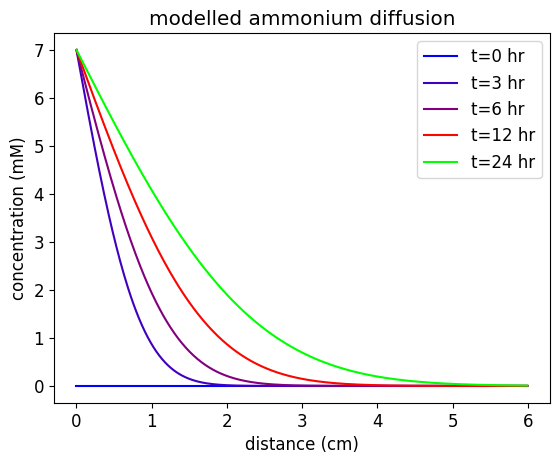

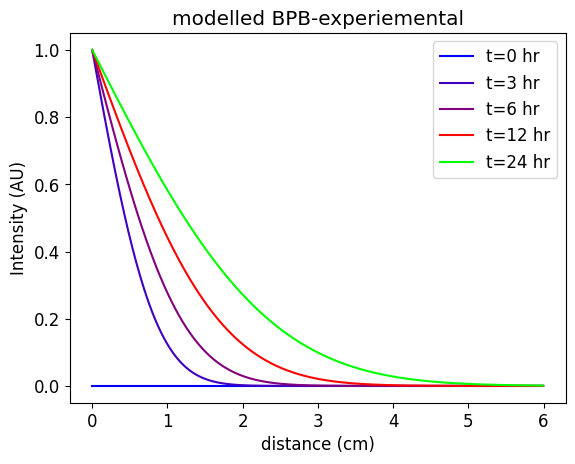

In [26]:
def modelling_diffusion(diffusion_coefficient, intitial_concentration, time_length_sec, xdata):
    modelling=np.zeros((time_length_sec, len(xdata)), dtype=float) #intitating an array
    for i in range(0,len(xdata)): #position (cm) loop, looping through i to save in correct index
        for time in range(1,86401): #time (sec) loop
            position=xData[i] #converting to position in cm
            modelling[time,i]=intitial_concentration*(1-math.erf(position/(2*math.sqrt(D*time)))) 
    return modelling

# global variables
time= 864001  #86400 seconds in 24 hours
#xData=(np.arange(0,6,6/(normalizedData.shape[1]-0.5))) # an array of position in cm (to match D in cm)

#coeffecients:
#D=0.0000044 #BPB predicted uncomment to see BPB

#modelling ammonium using the reported expeimental coefficient
#D=1.86E-5 #ammonium, https://bionumbers.hms.harvard.edu/bionumber.aspx?s=n&v=4&id=104437 #secondary source
D=1.95700E-5 #https://www.mdpi.com/1422-0067/23/10/5782
concentration=7 #the millimolar of ammonium in the source

modelling=modelling_diffusion(D, concentration,  864001, xData) #86400 seconds in 24 hours
for i in [0, 6, 12, 24, 47]:
    time_convert=i*30*60 # 39 minutes of 60 seconds each
    plt.plot(xData,modelling[time_convert], color=colors[i])
plt.legend(['t=0 hr', 't=3 hr','t=6 hr','t=12 hr','t=24 hr'])
plt.ylabel("concentration (mM)")
plt.xlabel("distance (cm)")
plt.title('modelled ammonium diffusion')
plt.show()
del modelling #memory intensive


#modelling BPB using the curve-fitted coefficient
modelling=modelling_diffusion(meanCoefficent, 1,  864001, xData) #86400 seconds in 24 hours
for i in [0, 6, 12, 24, 47]:
    time_convert=i*30*60 # 39 minutes of 60 seconds each
    plt.plot(xData,modelling[time_convert], color=colors[i])
plt.legend(['t=0 hr', 't=3 hr','t=6 hr','t=12 hr','t=24 hr'])
plt.ylabel("Intensity (AU)")
plt.xlabel("distance (cm)")
plt.title('modelled BPB-experiemental')
plt.show()

# Final figure
### plotting the experimental and modelled data of BPB

C:\Users\lexis\AppData\Local\Temp\ipykernel_19912\1331749057.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(np.flip(xData),modelling[to_plot[i]*30*60], "r--", alpha=0.9, linewidth=0.8, color=colors1[index])
C:\Users\lexis\AppData\Local\Temp\ipykernel_19912\1331749057.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(np.flip(xData),normalizedData[i], 'r-', linewidth=1.3,label=i, color=colors1[i])


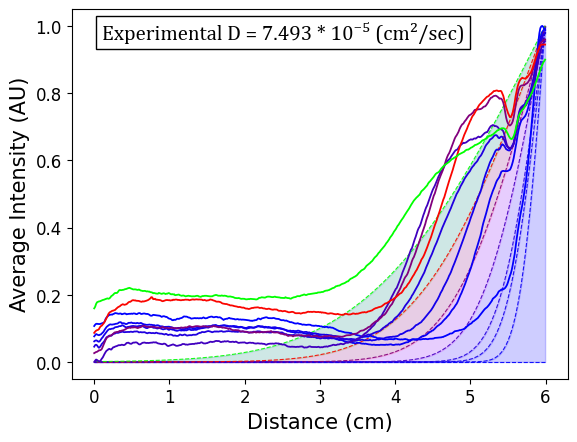

In [31]:
#flipping the axis:
xData=list((np.arange(0,6,6/(normalizedData.shape[1]-0.5))))

def adjust_color(color, brightness_factor=8, saturation_factor=0.4):
    hsv = rgb_to_hsv(color[:3])
    hsv[1] = np.clip(hsv[1] * saturation_factor, 0, 1)
    hsv[2] = np.clip(hsv[2] * brightness_factor, 0, 1)
    return hsv_to_rgb(hsv)

plt.rcParams.update({'font.size': 12})
original_cmap = plt.cm.brg

adjusted_colors = [adjust_color(original_cmap(i / len(colors)), 10, 10) for i in range(len(colors))]
adjusted_cmap = ListedColormap(adjusted_colors)
colors = adjusted_cmap(np.linspace(0, 1, 48)) #segmenting
colors1 = original_cmap = plt.cm.brg(np.linspace(0, 1, 48)) #original

to_plot=([0,1,2,3,6,12,24,47])
for i in range(0, len(to_plot)):
    index=to_plot[i]
    plt.plot(np.flip(xData),modelling[to_plot[i]*30*60], "r--", alpha=0.9, linewidth=0.8, color=colors1[index])
    plt.fill_between(np.flip(xData), modelling[to_plot[i-1]*30*60],modelling[to_plot[i]*30*60], color=colors[[to_plot[i]]], alpha=0.1)


for i in [0,1,2,3,6,12,24,47]:
    plt.plot(np.flip(xData),normalizedData[i], 'r-', linewidth=1.3,label=i, color=colors1[i])

plt.text(0.1, 0.96, "Experimental D = "+coeffStr, fontsize = 15, fontname='Cambria',
         bbox = dict(facecolor = 'white', alpha = 1))
plt.ylabel("Average Intensity (AU)", fontsize=15)
plt.xlabel("Distance (cm)",  fontsize=15)
plt.show()